In [1]:
NAME = "In Wai Cheong"
COLLABORATORS = "Ananth Kumar"

---

In [2]:
%matplotlib inline
%precision 16
import numpy
from scipy.special import erf, fresnel
import matplotlib.pyplot as plt

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

# HW 5:  Numerical Differentiation and Quadrature

## Question 1 - Basic  Quadrature Rules

The Error Function $\mathrm{erf}(x)$ is defined by the definite integral

$$
    \mathrm{erf}(x) = \frac{2}{\pi}\int_0^x e^{-t^2}dt
$$ 

We will use this function to test and understand the different errors associated with a range of both single interval and extended quadrature rules.  

Use the function definitions below to write a set of functions for approximating 
$$
 I[f] =  \int_a^b f(x) dx
$$ 
which we will use for testing against $\mathrm{erf}(x)$

**(a)** [8] Single step quadrature rules

Write short python functions for calculating $I[f]$ for the following newton-Cotes  quadrature rules on a single interval

* Left-Rectangle rule
* Mid-point rule
* Trapezoidal rule
* Simpson's Rule

In [3]:
def I_left(f, a, b):
    """ Left rectangle rule"""
    return f(a)*(b-a)
    
def I_midpoint(f, a, b):
    """ Newton-Cotes Midpoint rule"""
    # YOUR CODE HERE
    h = (b-a)/2
    return f(h)*(b-a)
     
def I_trapezoid(f, a, b):
    """ Newton-Cotes Midpoint rule"""
    # YOUR CODE HERE
    h = b-a
    return (h/2)*(f(a)+f(b)) 
    
def I_simpson(f, a, b):
    """ Newton-Cotes Simpsons rule"""
    # YOUR CODE HERE
    h = (b-a)/2
    return (h/3)*(f(a)+4*f(h)+f(b))    

In [4]:
# test against erf(1.)

x = 1.0
I_true = erf(x)
print('x = {}, erf(x) = {}\n'.format(x,I_true))
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)

I = numpy.zeros(4)
I[0] = I_left(f, 0., x)
I[1] = I_midpoint(f, 0., x)
I[2] = I_trapezoid(f, 0., x)
I[3] = I_simpson(f, 0., x)

err = numpy.abs( I - I_true)/numpy.abs(I_true)
answer = numpy.array([0.339003328982087,  0.0428168411464673,
          0.084202437312641, 0.0004770816600977])
numpy.testing.assert_allclose(err, answer)
print('success!')

x = 1.0, erf(x) = 0.8427007929497148

success!


**(b)** [8] Repeat the exercise for  3 point Gauss-Legendre Quadrature

* First:  calculates the weights $w_i$, using the method of undetermined coefficients such that the quadrature rule exactly integrates the monomials $1, x, x^2$ over the interval $x\in[-1,1]$.
(hint:  the 3 quadrature points $x_i$ are the roots of 

$$
    P_3(x) = (5x^3 - 3x)/2
$$
and this rule will exactly integrate polynomials up to order 5).

## Solution

The three roots of $P_3(x)$ are:

$$
x_1 = 0 \\
x_2 = \sqrt\frac{3}{5} \\
x_3 = -\sqrt\frac{3}{5}
$$

Let us first calculate $P'_3(x) = \frac{3}{2}(5x^2 - 1)$ and it's value at $x_1,x_2,x_3$:
$$
P'_3(x_1) = -\frac{3}{2} \\
P'_3(x_2) = 3 \\
P'_3(x_3) = 3
$$

Now for our weights:

$$
w_1 = \frac{2}{(1-{x_1}^2)(P'_3(x_1))^2} = \frac{8}{9}\\
w_2 = \frac{2}{(1-{x_2}^2)(P'_3(x_2))^2} = \frac{5}{9}\\
w_3 = \frac{2}{(1-{x_3}^2)(P'_3(x_3))^2} = \frac{5}{9}
$$

Next, implement your 3-point GL quadrature scheme to approximate 

$$
    \int_a^b f(x) dx
$$
for an arbitrary interval $x\in [a,b]$ (remember the affine mapping). 

In [5]:
def I_GL3(f, a, b):
    """ 3 point Gauss-Legendre Quadrature rule"""
    # YOUR CODE HERE
    w1 = 8/9
    w2 = 5/9
    w3 = 5/9
    p1 = 0
    p2 = numpy.sqrt(3/5)
    p3 = -numpy.sqrt(3/5)

    h = (b-a)/2
    h2 = (a+b)/2
    
    return h*(w1*f(p1*h + h2) + w2*f(p2*h + h2) + w3*f(p3*h + h2))

In [6]:
x = 1.0
I_true = erf(x)
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)

I = I_GL3(f, 0., x)
err = numpy.abs( I - I_true)/numpy.abs(I_true)
print('x = {}, erf(x) = {}'.format(x,I_true))
print('       I_GL3(x) = {}, err={}\n'.format(I,err))

answer = 1.2785635535382798e-05
numpy.testing.assert_allclose(err, answer)
print('success!')

x = 1.0, erf(x) = 0.8427007929497148
       I_GL3(x) = 0.8426900184845107, err=1.2785635535382798e-05

success!


**(c)** [8] Extended Quadrature rules. 

All of the above rules approximate the integral for a single "panel" over the interval $[a,b]$, but can be extended to calculate the quadrature of $N$ panels that subdivide the interval.  

Write a function that computes

$$
    I_N[f] = \int_a^b f(x) dx = \sum_{n=1}^N I_{method}[f]_n
$$


where $I_{method}[f]_n$ is one of the quadrature methods used above. 

Note, this won't be the most efficient way to implement many of these methods,  but that's not really the issue here.

In [7]:
def quadN(f, a, b, N, method=I_midpoint):
    """ 
    integrate a function f over the interval x in [a,b] using 
    an extended quadrature rule that implements a single interval
    quadrature rule over N panels of width (a - b)/N 
        
    Parameters:
    -----------
        
    f:  function f(x) (type real)
    a: real
        left boundary of interval
    b: real
        right boundary of interval
    N: integer
        number of panels to subdivide [a,b]
    method:  quadrature function with interface I(f, x0, x1) (real)
        returns quadrature approximation for subinterval [x0, x1]
        defaults to a midpoint rule
            
    Returns:
    --------
    I_N:  extended quadrature approximation of \int_a^b f(x) dx
        
    """
    # YOUR CODE HERE
    I_N = 0
    h = (b-a)/N      
    
    for i in range(N):
        I_N += f((a + h/2.0) + i*h)
    
    I_N = h*I_N
        
    return I_N    

In [8]:
# Let's test against erf(1)

x = 1.
I_true = erf(x)
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)

# set the number of panels in a list
N = [ 2**n for n in range (5)]

# integrate using the extended mid-point scheme and calculate relative errors for each N
err = numpy.zeros(len(N))
for i,n in enumerate(N):
    I = quadN(f, 0., x, n, method=I_midpoint)
    err[i] = numpy.abs(I - I_true)/numpy.abs(I_true)
    print('N = {}, I = {}, err = {}'.format(n, I, err[i]) )
    
answer = numpy.array([0.0428168411464673, 0.0104091587540129,
                      0.0025749021678512, 0.0006419796806984,
                      0.0001603854223201])
numpy.testing.assert_allclose(answer,err)
print('success!')
                    

N = 1, I = 0.8787825789354448, err = 0.042816841146467305
N = 2, I = 0.8514725992856609, err = 0.010409158754012854
N = 4, I = 0.844870665048331, err = 0.00257490216785125
N = 8, I = 0.843241789735697, err = 0.0006419796806984446
N = 16, I = 0.8428359498722815, err = 0.00016038542232009014
success!


**(d)** [10] Now *write a function* to make a plot that  compares the convergence behavior of all of the above methods (if you make it a function, you will be able to reuse it in the next  problem).

This function should  make a beautiful log-log plot showing the convergence behavior of the *relative error* with respect to 

$$
    I_{true} = \mathrm{erf}(1) = 0.8427007929497148
$$

for all the different quadrature rules for 

$$
    N = 2^n \quad \text{panels}\quad \text{for}\, n=0,1,\ldots,10
$$

remember to label all the curves with the methods.

Hint 1: there are some nice python tricks for doing this relatively efficiently, e.g. you can loop over a list of methods and extract the name with 

`name = method.__name__`


**Extra Credit** the rate of convergence of any scheme can be written as

$$
    |e| = C\Delta x^p
$$

For each method calculate $C$ and $p$ and plot the best fit straight-line in $\log(\Delta x)-\log(e)$ space (hint: `numpy.polyfit` is your friend). 

In [9]:
def plot_quad_convergence(f, a, b, N, I_true, title=None):
    """ create a convergence log-log plot that plots relative error of 
    various extended quadrature schemes vs panel spacing dx
    
    If really fancy, also calculates the best fit straight line in log-log space to estimate convergence
    parameters
    
    Parameters:
    -----------
        
    f:  function f(x) (type real)
    a: real
        left boundary of interval
    b: real
        right boundary of interval
    N: List of integers 
        number of panels to subdivide [a,b]
    I_true:  real
        True solution to compute errors
    title:  string
        title of plot (if not None)
            
    Returns:
    --------
    Nothing but generates a pretty log-log plot all properly labeled
    
    """
    # YOUR CODE HERE
    num_partitions = numpy.array([ 2**n for n in range(0, 11)])
    delta_x = numpy.empty(len(num_partitions))
    error_mid = numpy.empty(len(num_partitions))
    error_rect = numpy.empty(len(num_partitions))
    error_trap = numpy.empty(len(num_partitions))
    error_simpson = numpy.empty(len(num_partitions))
    error_GL3 = numpy.empty(len(num_partitions))
    
    for (j, N) in enumerate(num_partitions):
        x_hat = numpy.linspace(0.0, 1.0, N + 1)
        delta_x[j] = x_hat[1] - x_hat[0]
        
    #Compute Rectangle
        x_star = x_hat[0:]
        I_hat = 0.0
        for i in range(0, N):
            I_hat += f(x_star[i]) * delta_x[j]
        error_rect[j] = numpy.abs(I_hat - I_true)/I_true

    # Compute Midpoint
        x_star = 0.5 * (x_hat[1:] + x_hat[:-1])
        I_hat = 0.0
        for i in range(0, N):
            I_hat += f(x_star[i]) * delta_x[j]
        error_mid[j] = numpy.abs(I_hat - I_true)/I_true
        
     # Compute trapezoid
        I_hat = 0.0
        for i in range(1, N):
            I_hat += (f(x_hat[i + 1]) + f(x_hat[i])) * delta_x[j] / 2.0
        error_trap[j] = numpy.abs(I_hat - I_true)/I_true
    
    # Compute simpson's    
        I_hat = 0.0
        for i in range(0, N):
            I_hat += delta_x[j] * (1.0 / 6.0 * (f(x_hat[i]) + f(x_hat[i+1])) + 2.0 / 3.0 * f(x_hat[i] + delta_x[j] / 2.0))
        error_simpson[j] = numpy.abs(I_hat - I_true)/I_true    
    
    # Compute GL3
        xi_map = lambda a,b,xi : (b - a) / 2.0 * xi + (a + b) / 2.0
        xi = [-numpy.sqrt(3.0 / 5.0), 0.0, numpy.sqrt(3.0 / 5.0)]
        w = [5.0 / 9.0, 8.0 / 9.0, 5.0 / 9.0]
        I_hat = 0.0
        for i in range(0, N - 1):
            for k in range(len(xi)):
                I_hat += f(xi_map(x_hat[i], x_hat[i+1], xi[k])) * w[k]
        I_hat *= delta_x[j] / 2.0
        error_GL3[j] = numpy.abs(I_hat - I_true)/I_true
        
    fig = plt.figure(figsize=(8,6))
    axes = fig.add_subplot(1,1,1)
    axes.loglog(delta_x, error_mid,'bo-', label="Midpoint")
    axes.loglog(delta_x, error_trap, 'ro-', label="Trapezoid")
    axes.loglog(delta_x, error_simpson, 'go-', label="Simpson's")
    axes.loglog(delta_x, error_rect, 'yo-', label='Rectangle')
    axes.loglog(delta_x, error_GL3, 'co-',label='GL3')
    axes.set_xlabel('$\Delta x$',fontsize=16)
    axes.set_ylabel('Relative Error')
    axes.set_title(title)
    axes.legend()
    axes.grid()

    plt.show()
    
    

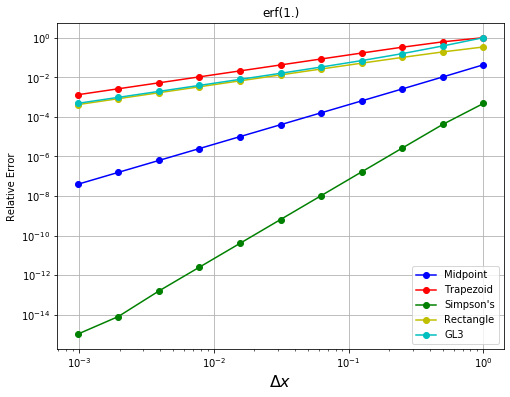

In [10]:
#Let's test with erf(1) and a lot of points

x = 1.
I_true = erf(x)
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)    

N = [ 2**n for n in range (11)]

plot_quad_convergence(f, 0., 1., N, I_true, 'erf(1.)')

**(e)** [3] Estimate the number of function evaluations required to get a relative error $e \approx 10^{-7}$ i.e. about 7 digits of precision for the schemes

* Mid-point
* Simpson's
* 3-Pt GL quadrature


## Solution

Midpoint: Appears to be about $2^1=2$ function evaluations <br>
Simpsons: Appears to be about $2^8=256$ function evaluations <br>
GL3: Doesn't seem to start with a lower relative error than $10^-7$

## Question 2

Let's repeat the problem with a harder integral.

Consider the scaled Fresnel integrals

$$I_c = \int^1_0 \frac{\cos x}{\sqrt{x}} dx~~~~\text{and}~~~~I_s = \int^1_0 \frac{\sin x}{\sqrt{x}} dx$$

which have values

$$I_c = \sqrt{2 \pi} \cdot C\left(\sqrt{\frac{2}{\pi}}\right) \approx 1.8090484758005438$$

$$I_s = \sqrt{2 \pi} \cdot S\left(\sqrt{\frac{2}{\pi}}\right) \approx 0.62053660344676231$$

where the functions $C(x)$ and $S(x)$ can be evaluated by `scipy.special.fresnel`.


**(a)** [2] Where do you imagine the problematic points of the integrals will be?

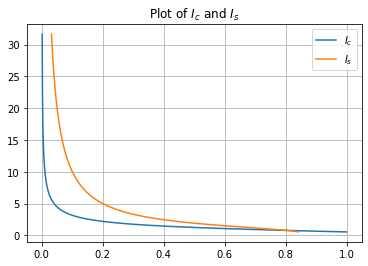

In [11]:
x = numpy.arange(0.001,1,0.0001)
y = numpy.cos(x)/numpy.sqrt(x)
z = numpy.sin(x)/numpy.sqrt(x)
plt.plot(x,y,label='$I_c$')
plt.plot(z,y,label='$I_s$')
plt.title("Plot of $I_c$ and $I_s$")
plt.legend()
plt.grid()

## Solution

Based on the graph above, the problematic point on both integrals would be at $0$, since it appears to approach $\infty$.

**(b)** [4] Use your convergence plotting routine to make  2 plots showing convergence behavior for all the extended quadrature rules for $I_c$ and $I_s$ 

In [12]:
# Set the True solutions for reference
Is_true, Ic_true = fresnel(numpy.sqrt(2.0 / numpy.pi))
Is_true *= numpy.sqrt(2.0 * numpy.pi)
Ic_true *= numpy.sqrt(2.0 * numpy.pi)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


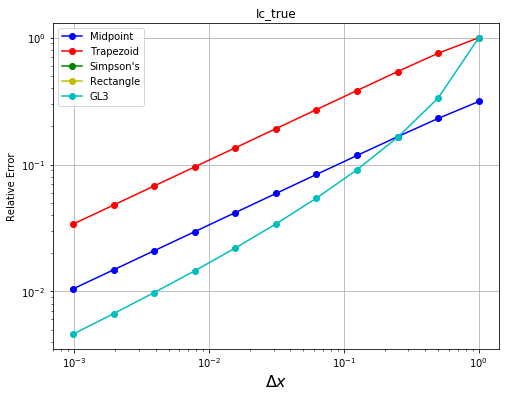

In [13]:
# YOUR CODE HERE
f=lambda x: numpy.cos(x)/numpy.sqrt(x)
N = [ 2**n for n in range (11)]
plot_quad_convergence(f, 0., 1., N, I_true=Ic_true,title='Ic_true')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


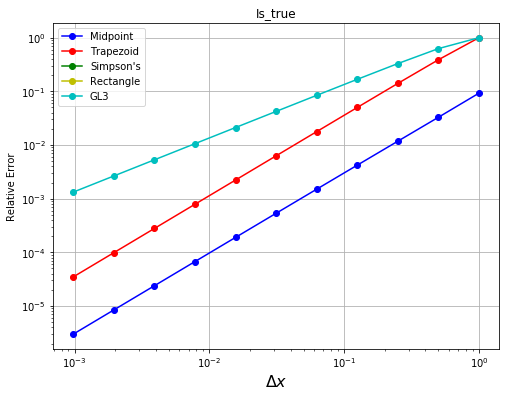

In [14]:
f=lambda x: numpy.sin(x)/numpy.sqrt(x)
N = [ 2**n for n in range (11)]
plot_quad_convergence(f, 0., 1., N, I_true=Is_true,title='Is_true')

**(c)**  [4] Explain the results of your plots

## Solution

Simpson's and Rectangle rule does not appear to be showing, I'm assuming because those two schemes will never reach a low relative error or even converge.
<br>
As far as the other schemes, trapezoidal rule does best for $I_c$ and GL-3 does best for $I_s$. However, GL3, midpoint, and trapezoidal all seem to tend toward a relatively low error.

**(d)** [4] show that the convergence and the quadrature schemes can be dramatically improved simply by tranforming the variable $x$ with $x=t^2$

1. Show analytically what the transformed integral should be
2. produce two more plots demonstrating convergence behaviour
3. comment on the results

## Solution

Analytically, the transformed integral should look like:

$$
\int_0^1 \frac{cos(t^2)}{t} dt \\
\int_0^1 \frac{sin(t^2)}{t} dt
$$

I am most likely doing this wrong, and can't seem to figure out why - since my relative errors seem to be worse, and trapezoidal rule even has a spike. GL-3 is the only one that seems to converge in a stable way, even though it eventually ocnverges. Midpoint has a low relatively error at around $2^8$ function evaluations but the increases again. Maybe with higher evaluations, it could be better?

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


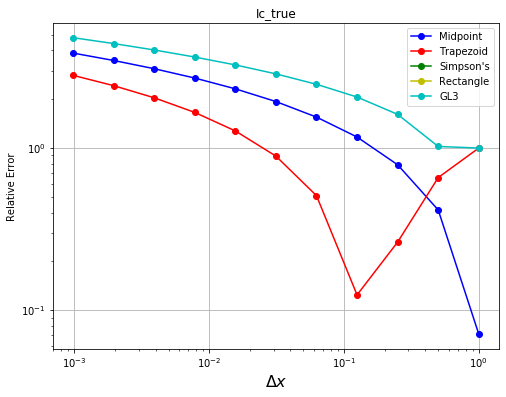

In [15]:
# YOUR CODE HERE
f=lambda t: numpy.cos(t**2)/t
N = [ 2**n for n in range (11)]
plot_quad_convergence(f, 0., x, N, I_true=Ic_true,title='Ic_true')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


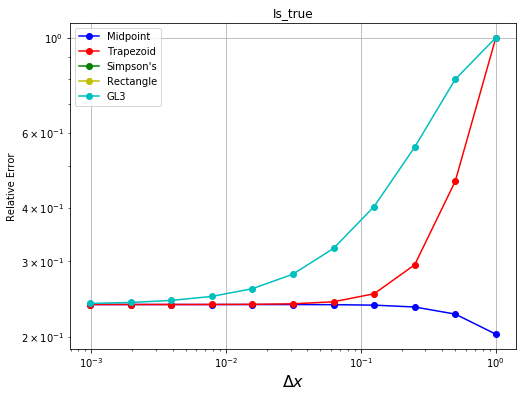

In [16]:
f=lambda t: numpy.sin(t**2)/t
N = [ 2**n for n in range (11)]
plot_quad_convergence(f, 0., 1, N, I_true=Is_true,title='Is_true')

## Question 3

We can often reformulate finite difference approximations as matrix-vector products.  For the following problem, assume that the data considered are equispaced points $(x_i, y_i)$, i.e. $\Delta x$ is uniform.  

Here we will construct a matrix   $D$  such that multiplying a vector of $\mathbf{y}$ values would lead to a second order approximation of the First derivative for the given data. 

In other words for  $y_i = f(x_i)$

$$
f'(x) \approx D\mathbf{y}
$$

**(a)** [8] Derive the forward, centered and  backward second order finite difference approximations to the first derivative using the method of your choice.

I.e. given 3 equispaced points $x_i, x_{i+1}, x_{i+2}$  calculate the consistent 2nd order, *1st derivative* operator evaluated at each point.  

* hint 1:  consider the interpolating polynomial $P_2(x)$ through those 3 points and calculate $P'_2(x)$ at each point.
* hint 2:  the method of undetermined coefficients on Taylor's series can be useful here as well

**Extra Credit**: Find the consistent 2nd order *2nd derivative* evaluated at each point

## Solution

For forward, we have that:

$$
f'(x) \approx P'_2(x) = [y_0, y_1] + ((x - x_1) + (x - x_0)) [y_0, y_1, y_2] \\
= \frac{y_1-y_0}{x_1-x_0} + ((x-x_1)+(x-x_0)) \left (\frac{y_2 - y_1}{(x_2 - x_1)(x_2 - x_0)} - \frac{y_1 - y_0}{(x_1 - x_0)(x_2 - x_0)} \right) \\
= \frac{f(x_1)-f(x_0)}{x_1 - x_0} + (2x-x_1-x_0) \left (\frac{f(x_2) - f(x_1)}{(x_2 - x_1)2\Delta x} - \frac{f(x_1)-f(x_0)}{(x_1-x_0)2\Delta x} \right) \\
\fbox{$f'(x_0) = \frac{-3f(x_0)+4f(x_1)-f(x_2)}{2\Delta x}$}
$$

For backward, we have that:

$$
f'(x) \approx P'_2(x) = [y_1,y_0] + ((x - x_1)+(x-x_2))[y_2,y_1,y_0] \\
= \frac{y_0-y_1}{x_0-x_1} + ((x-x_2)+(x-x_1))(\frac{y_0 - y_1}{(x_0 - x_1)(x_0 - x_2)} - \frac{y_1 - y_2}{(x_1 - x_2)(x_0 - x_2)}) \\
= \frac{f(x_0)-f(x_1)}{x_0-x_1} + (2x-x_1-x_2) \left (\frac{f(x_0)-f(x_1)}{(x_0-x_1)2\Delta x} - \frac{f(x_1)-f(x_2)}{(x_1-x_2)2\Delta x} \right ) \\
\fbox{$f'(x_2) = \frac{f(x_0)-4f(x_1)+3f(x_2)}{2\Delta x}$}
$$

For centered, we have that:

$$
f'(x) \approx P'_2(x) = [y_0,y_1] + ((x-x_2)+(x-x_1))[y_1,y_2,y_0] \\
= \frac{y_1 - y_0}{x_1 - x_0} + ((x-x_2)+(x-x_1)) \left (\frac{y_0 - y_2}{(x_0 - x_2)(x_0 - x_1)} - \frac{y_2 - y_1}{(x_2 - x_1)(x_0 - x_1)} \right) \\
= \frac{f(x_1)-f(x_0)}{x_1-x_0}+(2x-x_1-x_2) \left (\frac{f(x_0)-f(x_2)}{(x_0-x_2)2\Delta x} - \frac{f(x_2)-f(x_1)}{(x_2-x_1)2\Delta x} \right) \\
\fbox{$ f'(x_1) = \frac{f(x_2)-f(x_0)}{2\Delta x}$}
$$

**(b)** [4] Now consider an equispaced set of points  $y_i = f(x_i)$, can you describe the structure of a consistent 2nd order, first derivative matrix $D$,  such that 

$$
    f'(x) \approx D\mathbf{y}
$$

returns the consistent 1st derivative at every point (including the end points)

## Solution

$$
\frac{1}{2\Delta x}
\begin{bmatrix} 
-3 & 4 & -1 \\
-1 & 0 & 1\\
1 & -4 & 3 \\
\end{bmatrix}
\begin{bmatrix} 
f(x_0) \\
f(x_1) \\
f(x_2) \\
\end{bmatrix}
=
\begin{bmatrix} 
f'(x_1) \\
f'(x_2) \\
f'(x_3) \\
\end{bmatrix}
$$

**(c)** [8] Write a function that takes in the number of data points $N$ and returns the matrix $D$ (which is a 2-D numpy array of size $N\times N$).  Here assume we are on the interval $[-1, 1]$.  Note that inside your function 
$$
    \Delta x = \frac{2}{N - 1}
$$
to match the `linspace` command.

Beyond being convenient (once you construct the matrix you can apply it to any set of data) this operation is much faster than using loops.  *Hint:* The command `numpy.diag` may be extremely helpful.

In [41]:
def diff_matrix(N):
    # YOUR CODE HERE
    delta_x = 2/(N-1)
    mat = numpy.array([-3,4,-1,-1,0,1,1,-4,3])
    mat2 = mat.reshape(3,3)
    D = (1/(2*delta_x))*mat2
    return D

In [42]:
# Let's test this using f(x) = exp(2.*x) and 100 points

N = 100
x = numpy.linspace(-1, 1, N)
y = numpy.exp(2.0 * x)
y_prime = 2.*numpy.exp(2. * x)

numpy.testing.assert_allclose(numpy.dot(diff_matrix(N), y), y_prime, rtol=1e-2)
print("Success!")

ValueError: shapes (3,3) and (100,) not aligned: 3 (dim 1) != 100 (dim 0)

**(c)** [4] Suppose we knew the *first derivative* of a function $f(x)$ at a discrete set of points and wanted to solve for the discrete function itself.  i.e.  ideally given $D$ and vector $\mathbf{y} = f'(\mathbf{x})$,  we would like to be able to solve the linear algebra problem

$$
    D\mathbf{f} = \mathbf{y}
$$

for $\mathbf{f}\approx f(\bf{x})$.  Discuss any issues we might have with this approach.

## Solution

$D$ might not necessarily be invertible, and it highly depends on the number of points you have, which could lead to $D$ being undefined. 